In [1]:
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import seaborn as sns

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

### Loading the Apriori Output

In [3]:
df = pd.read_csv('apriori_output.csv')
df.shape

(222, 3)

In [4]:
df.head()

,first,second,label
0,['Bunched Cilantro'],['Organic Cilantro'],0
1,['Organic Cilantro'],['Bunched Cilantro'],0
2,['Extra Virgin Olive Oil'],['Organic Cilantro'],0
3,['Organic Cilantro'],['Extra Virgin Olive Oil'],0
4,['Extra Virgin Olive Oil'],['Organic Italian Parsley Bunch'],0


In [5]:
df.label.unique()

array([0, 1, 2], dtype=int64)

## Plot of Label Distribution

Text(0, 0.5, 'Count')

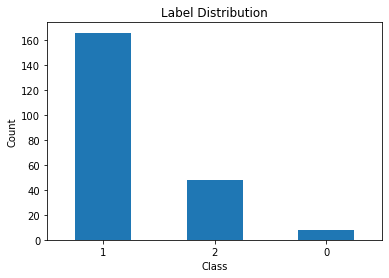

In [6]:
count_labels = pd.value_counts(df['label'])
count_labels.plot(kind='bar', rot=0)
plt.title('Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

#### So there is a class imbalance present in the dataset

## Cleaning the dataset

In [7]:
df["first"]= df["first"].str.replace('\']','')
df["first"]= df["first"].str.replace('\[\'','')
df["first"]= df["first"].str.replace(',','')
df["first"]= df["first"].str.replace('&','')
df["first"]= df["first"].str.replace('\'','')

<ipython-input-7-c9a27a7e8e0c>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["first"]= df["first"].str.replace('\']','')
<ipython-input-7-c9a27a7e8e0c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["first"]= df["first"].str.replace('\[\'','')


In [8]:
df["second"]= df["second"].str.replace('\']','')
df["second"]= df["second"].str.replace('\[\'','')
df["second"]= df["second"].str.replace(',','')
df["second"]= df["second"].str.replace('&','')
df["second"]= df["second"].str.replace('\'','')

<ipython-input-8-cd583d526238>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["second"]= df["second"].str.replace('\']','')
<ipython-input-8-cd583d526238>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["second"]= df["second"].str.replace('\[\'','')


In [9]:
# Train Model
train_model = df[['first','label']]

In [10]:
predict = df[['label','second']]

## Prepare dataframes for top 5 products in each label

### Top 5 List of Products to be recommended for label 0

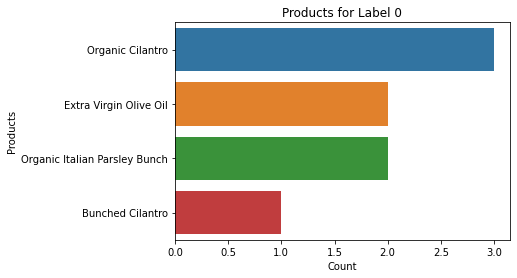

In [11]:
label_0 = predict[predict['label'] == 0]
label_0.drop(columns='label', inplace=True)

vals = label_0.value_counts(sort=True, ascending=False)
df_val_counts = pd.DataFrame(vals)
label_0 = df_val_counts.reset_index()
label_0.columns = ['products', 'counts'] # change column names
# label_0.index = label_0['counts']

ax = sns.barplot(y = label_0.products, x = label_0.counts)
ax.set_ylabel("Products")
ax.set_xlabel("Count")
ax.set_title("Products for Label 0")
plt.show()

### Top 5 List of Products to be recommended for label 1

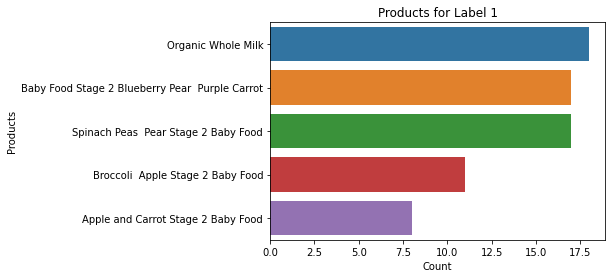

In [12]:
label_1 = predict[predict['label'] == 1]
label_1.drop(columns='label', inplace=True)

vals = label_1.value_counts(sort=True, ascending=False)
df_val_counts = pd.DataFrame(vals)
label_1 = df_val_counts.reset_index()
label_1.columns = ['products', 'counts'] # change column names
# label_1 = label_1.head()
# label_1.drop(columns=['counts'])

# fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(y = label_1.products[:5], x = label_1.counts[:5])
ax.set_ylabel("Products")
ax.set_xlabel("Count")
ax.set_title("Products for Label 1")
plt.show()

### Top 5 List of Products to be recommended for label 2

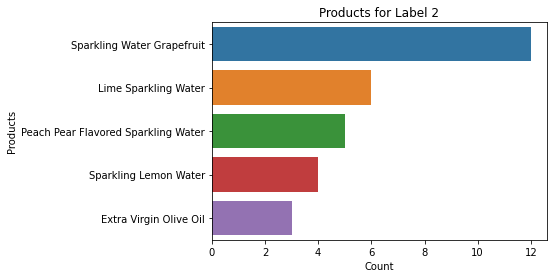

In [13]:
label_2 = predict[predict['label'] == 2]
label_2.drop(columns='label', inplace=True)

vals = label_2.value_counts(sort=True, ascending=False)
df_val_counts = pd.DataFrame(vals)
label_2 = df_val_counts.reset_index()
label_2.columns = ['products', 'counts'] # change column names
# label_2 = label_2.head()
# label_2


ax = sns.barplot(y = label_2.products[:5], x = label_2.counts[:5])
ax.set_ylabel("Products")
ax.set_xlabel("Count")
ax.set_title("Products for Label 2")
plt.show()

In [14]:
labels = train_model['label']
dataset = train_model['first']

## Fix Class Imbalance

### To fix class imbance, it is better to go with over sampling because our dataset doesn't contains a large number of records. With oversampling we will not miss any useful data as well.

In [15]:
ros = RandomOverSampler(random_state=42)

In [16]:
X_ros, y_ros = ros.fit_resample(dataset.values.reshape(-1,1), labels)

print('original dataset shape:', Counter(labels))
print('Resample dataset shape', Counter(y_ros))

original dataset shape: Counter({1: 166, 2: 48, 0: 8})
Resample dataset shape Counter({0: 166, 1: 166, 2: 166})


Text(0, 0.5, 'Count')

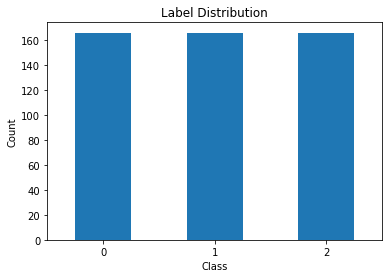

In [17]:
count_labels = pd.value_counts(y_ros)
count_labels.plot(kind='bar', rot=0)
plt.title('Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

In [18]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

In [19]:
X_train = X_train.flatten()
X_test = X_test.flatten()

## NLP

### Bag of Words

In [20]:
bow_vect = CountVectorizer(ngram_range=(1,1))

In [21]:
X_train_bow = bow_vect.fit_transform(X_train)

In [22]:
X_train_bow_arr = X_train_bow.toarray()

In [23]:
#BOW Representation
bow_dataframe = pd.DataFrame(X_train_bow_arr, columns=bow_vect.get_feature_names())
print(bow_dataframe)

     and  apple  apples  apricot  baby  banana  bean  beans  berry  black  \
0      1      0       0        0     2       0     0      0      0      0   
1      0      0       0        0     0       0     0      0      0      0   
2      0      0       0        0     0       0     0      0      0      0   
3      0      0       0        0     0       0     0      0      0      0   
4      0      0       0        0     0       0     0      0      0      0   
..   ...    ...     ...      ...   ...     ...   ...    ...    ...    ...   
393    0      0       0        0     0       0     0      0      0      0   
394    0      0       0        0     0       0     0      0      0      0   
395    0      0       0        0     0       0     0      0      0      0   
396    0      0       0        0     0       0     0      0      0      0   
397    0      0       0        0     0       0     0      0      0      0   

     ...  strawberry  string  superfoods  sweeet  sweet  virgin  water  who

### TF-IDF

In [24]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,1))

In [25]:
X_train_tfidf = tfidf_vect.fit_transform(X_train)

In [26]:
X_train_tfidf_arr = X_train_tfidf.toarray()

In [27]:
#TF-IDF Representation
tfidf_dataframe = pd.DataFrame(X_train_tfidf_arr, columns=tfidf_vect.get_feature_names())
print(tfidf_dataframe)

          and  apple  apples  apricot     baby  banana  bean  beans  berry  \
0    0.348819    0.0     0.0      0.0  0.44864     0.0   0.0    0.0    0.0   
1    0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   
2    0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   
3    0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   
4    0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   
..        ...    ...     ...      ...      ...     ...   ...    ...    ...   
393  0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   
394  0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   
395  0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   
396  0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   
397  0.000000    0.0     0.0      0.0  0.00000     0.0   0.0    0.0    0.0   

     black  ...  strawberry  string  superfoods  sweeet  sweet 

## Classification

In [28]:
# Naive Bayes
clf = MultinomialNB()

In [29]:
# Random Forest
rfc = RandomForestClassifier()

In [51]:
# Sypport Vector Classifier
svm = SVC(kernel='linear')

#### Classification using Bag of Words

In [31]:
X_test_bow = bow_vect.transform(X_test)
X_test_bow_arr = X_test_bow.toarray()

In [32]:
clf.fit(X_train_bow_arr, y_train)

MultinomialNB()

In [33]:
rfc.fit(X_train_bow_arr, y_train)

RandomForestClassifier()

In [34]:
svm.fit(X_train_bow_arr, y_train)

SVC(kernel='linear')

#### Classification Report and Confusion Matrix for different models w.r.t Bag-of-Words

##### For Naive Bayes

In [35]:
print(classification_report(y_test, clf.predict(X_test_bow_arr), digits=4))

              precision    recall  f1-score   support

           0     0.6829    1.0000    0.8116        28
           1     1.0000    0.8108    0.8955        37
           2     0.9655    0.8000    0.8750        35

    accuracy                         0.8600       100
   macro avg     0.8828    0.8703    0.8607       100
weighted avg     0.8992    0.8600    0.8648       100



In [36]:
confusion_matrix(y_test, clf.predict(X_test_bow_arr))

array([[28,  0,  0],
       [ 6, 30,  1],
       [ 7,  0, 28]], dtype=int64)

##### For Random Forest Classifier

In [37]:
print(classification_report(y_test, rfc.predict(X_test_bow_arr), digits=4))

              precision    recall  f1-score   support

           0     0.7000    1.0000    0.8235        28
           1     1.0000    0.8378    0.9118        37
           2     0.9655    0.8000    0.8750        35

    accuracy                         0.8700       100
   macro avg     0.8885    0.8793    0.8701       100
weighted avg     0.9039    0.8700    0.8742       100



In [38]:
confusion_matrix(y_test, rfc.predict(X_test_bow_arr))

array([[28,  0,  0],
       [ 5, 31,  1],
       [ 7,  0, 28]], dtype=int64)

##### For Support Vector Classifier

In [39]:
print(classification_report(y_test, svm.predict(X_test_bow_arr), digits=4))

              precision    recall  f1-score   support

           0     0.7000    1.0000    0.8235        28
           1     1.0000    0.8378    0.9118        37
           2     0.9655    0.8000    0.8750        35

    accuracy                         0.8700       100
   macro avg     0.8885    0.8793    0.8701       100
weighted avg     0.9039    0.8700    0.8742       100



In [40]:
confusion_matrix(y_test, svm.predict(X_test_bow_arr))

array([[28,  0,  0],
       [ 5, 31,  1],
       [ 7,  0, 28]], dtype=int64)

#### Classification using TF-IDF

In [41]:
X_test_tfidf = tfidf_vect.transform(X_test)
X_test_tfidf_arr = X_test_tfidf.toarray()

In [42]:
clf.fit(X_train_tfidf_arr, y_train)

MultinomialNB()

In [43]:
rfc.fit(X_train_tfidf_arr, y_train)

RandomForestClassifier()

In [44]:
svm.fit(X_train_tfidf_arr, y_train)

SVC(kernel='linear')

#### Classification Report and Confusion Matrix for different models w.r.t TF-IDF

##### For Naive Bayes

In [45]:
print(classification_report(y_test, clf.predict(X_test_tfidf_arr), digits=4))

              precision    recall  f1-score   support

           0     0.7000    1.0000    0.8235        28
           1     1.0000    0.8378    0.9118        37
           2     0.9655    0.8000    0.8750        35

    accuracy                         0.8700       100
   macro avg     0.8885    0.8793    0.8701       100
weighted avg     0.9039    0.8700    0.8742       100



In [46]:
confusion_matrix(y_test, clf.predict(X_test_tfidf_arr))

array([[28,  0,  0],
       [ 5, 31,  1],
       [ 7,  0, 28]], dtype=int64)

##### For Random Forest Classifier

In [47]:
print(classification_report(y_test, rfc.predict(X_test_tfidf_arr), digits=4))

              precision    recall  f1-score   support

           0     0.7000    1.0000    0.8235        28
           1     1.0000    0.8378    0.9118        37
           2     0.9655    0.8000    0.8750        35

    accuracy                         0.8700       100
   macro avg     0.8885    0.8793    0.8701       100
weighted avg     0.9039    0.8700    0.8742       100



In [48]:
confusion_matrix(y_test, rfc.predict(X_test_tfidf_arr))

array([[28,  0,  0],
       [ 5, 31,  1],
       [ 7,  0, 28]], dtype=int64)

##### For Support Vector Classifier

In [49]:
print(classification_report(y_test, svm.predict(X_test_tfidf_arr), digits=4))

              precision    recall  f1-score   support

           0     0.7000    1.0000    0.8235        28
           1     1.0000    0.8378    0.9118        37
           2     0.9655    0.8000    0.8750        35

    accuracy                         0.8700       100
   macro avg     0.8885    0.8793    0.8701       100
weighted avg     0.9039    0.8700    0.8742       100



In [50]:
confusion_matrix(y_test, svm.predict(X_test_tfidf_arr))

array([[28,  0,  0],
       [ 5, 31,  1],
       [ 7,  0, 28]], dtype=int64)

## Observation

### The Classification Results for all the models are almost same. The reason for this might be smaller dataset which we got from Apriori Output. So, here we cannot make a judgement regarding which NLP Algorithm or which classification model worked best. So we can use any combination of NLP and classification models. If there had been a huge dataset from Apriori then models might have performed differently.